# Proyecto: Reconocimiento de Dígitos Manuscritos con CNN (MNIST) en R

**Inicio del Proyecto:** Adaptación del análisis de CNN sobre MNIST a R.

## Metodología: Metodología Fundacional de IBM para Ciencia de Datos

Estructuraremos este análisis usando la **Metodología Fundacional de IBM para Ciencia de Datos**, que incluye las siguientes etapas iterativas:

1. **Enfoque Analítico**: Definición del problema.  
2. **Requerimientos de Datos**: Identificación de los datos necesarios.  
3. **Recolección de Datos**: Obtención de los datos.  
4. **Comprensión de Datos**: Estadísticas descriptivas y visualización.  
5. **Preparación de Datos**: Limpieza y preprocesamiento.  
6. **Modelado**: Construcción del modelo de IA.  
7. **Evaluación**: Valoración del desempeño del modelo.  
8. **Despliegue**: Disponibilización del modelo.


In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(keras)
library(tensorflow)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")
set.seed(123)
tf$random$set_seed(123)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "mnist-dataset"

# Fase 1: Enfoque Analítico

**Objetivo**: Clasificar imágenes en escala de grises de dígitos manuscritos (0-9) en sus respectivas categorías.  
**Técnica**: Aprendizaje profundo utilizando Redes Neuronales Convolucionales (CNN), que son altamente efectivas para tareas de reconocimiento de imágenes debido a su capacidad para capturar jerarquías espaciales.

# Fase 2 y 3: Requerimientos y Recolección de Datos

Para este proyecto se emplea el reconocido **conjunto de datos MNIST**, que contiene imágenes de dígitos manuscritos del 0 al 9. En entornos como Kaggle, los datos suelen estar disponibles en formato IDX binario o CSV. Para este análisis, se asume que los archivos IDX se encuentran en la ruta `../input/mnist-dataset/`.

In [2]:
# Funciones auxiliares para leer archivos en formato IDX manualmente en R
read_idx_images <- function(path) {
  f <- file(path, "rb")
  on.exit(close(f))
  
  magic <- readBin(f, integer(), n=1, endian="big")
  num_images <- readBin(f, integer(), n=1, endian="big")
  rows <- readBin(f, integer(), n=1, endian="big")
  cols <- readBin(f, integer(), n=1, endian="big")
  
  data <- readBin(f, integer(), n=num_images * rows * cols, size=1, signed=FALSE)
  
  array(data, dim = c(cols, rows, num_images)) %>% 
    aperm(c(3, 2, 1))
}

read_idx_labels <- function(path) {
  f <- file(path, "rb")
  on.exit(close(f))
  
  magic <- readBin(f, integer(), n=1, endian="big")
  num_items <- readBin(f, integer(), n=1, endian="big")
  
  readBin(f, integer(), n=num_items, size=1, signed=FALSE)
}

# Definir rutas
base_path <- "../input/mnist-dataset"
train_img_path <- file.path(base_path, "train-images.idx3-ubyte")
train_lbl_path <- file.path(base_path, "train-labels.idx1-ubyte")
test_img_path <- file.path(base_path, "t10k-images.idx3-ubyte")
test_lbl_path <- file.path(base_path, "t10k-labels.idx1-ubyte")

# Cargar datos
tryCatch({
    x_train_raw <- read_idx_images(train_img_path)
    y_train_raw <- read_idx_labels(train_lbl_path)
    x_test_raw <- read_idx_images(test_img_path)
    y_test_raw <- read_idx_labels(test_lbl_path)
    
    cat("Imágenes de entrenamiento:", dim(x_train_raw), "\n")
    cat("Etiquetas de entrenamiento:", length(y_train_raw), "\n")

    cat("Imágenes de prueba:", dim(x_test_raw), "\n")
    cat("Etiquetas de prueba:", length(y_test_raw), "\n")
}, error = function(e) {
    cat("Error al cargar los archivos. Verificar rutas:", list.files("../input/mnist-dataset"), "\n")
    print(e)
})


Imágenes de entrenamiento: 60000 28 28 
Etiquetas de entrenamiento: 60000 
Imágenes de prueba: 10000 28 28 
Etiquetas de prueba: 10000 


# Fase 4: Comprensión de Datos

Visualizamos algunas muestras para verificar la integridad de los datos y entender el formato de entrada.

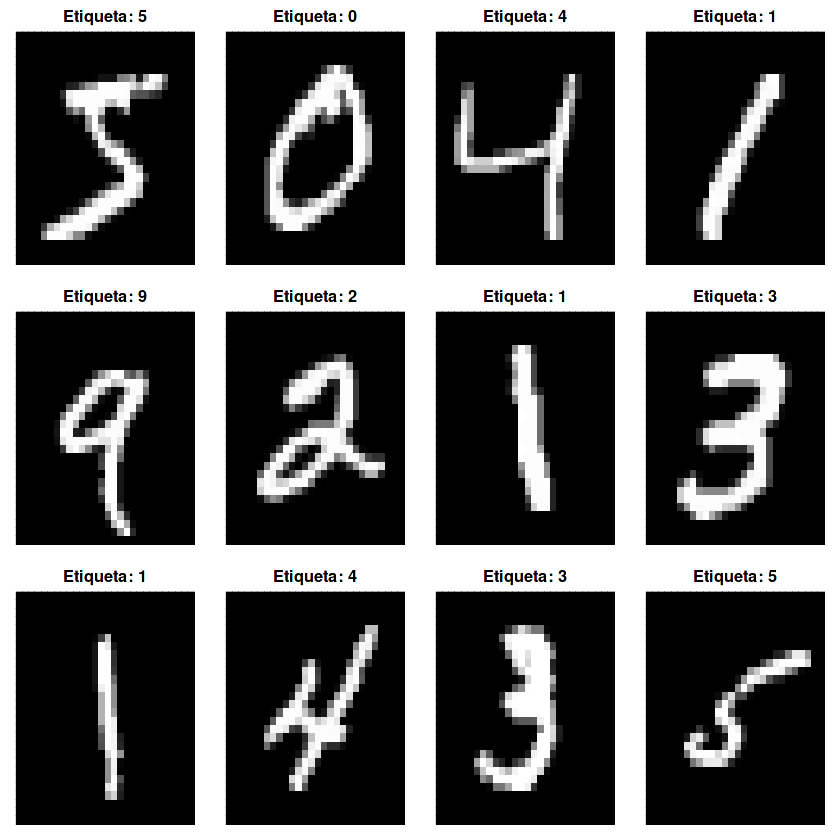

In [3]:
# Visualizar las primeras muestras
par(mfrow=c(3,4), mar=c(1,1,2,1))
for (i in 1:12) {
  img_mat <- x_train_raw[i, , ]
  img_mat <- t(apply(img_mat, 2, rev))
  
  image(1:28, 1:28, img_mat, col=gray((0:255)/255), axes=FALSE, 
        main=paste("Etiqueta:", y_train_raw[i]))
}

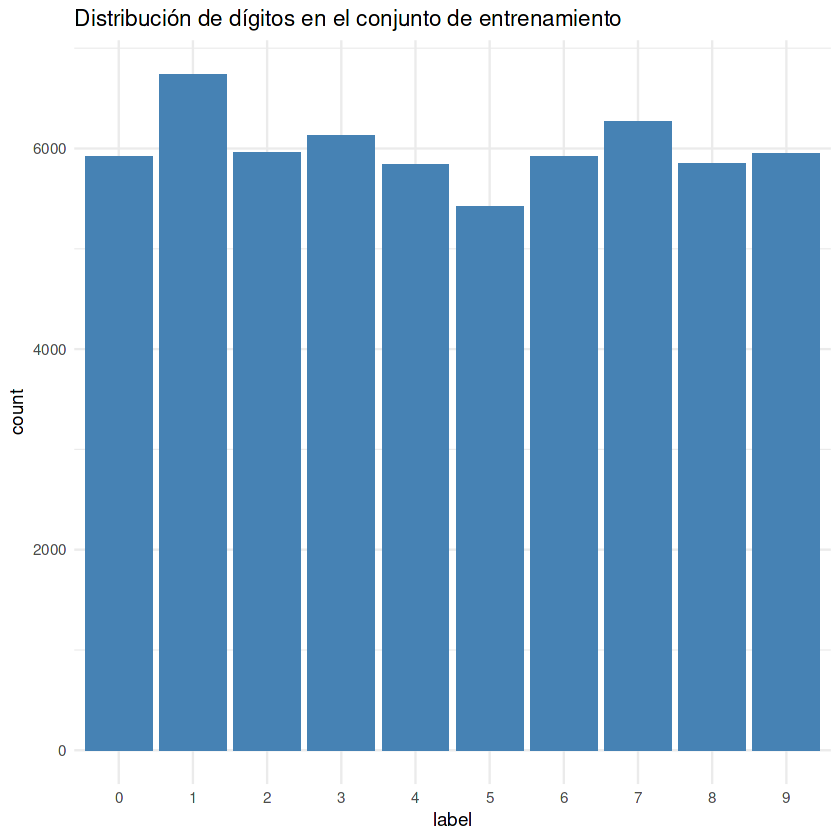

In [4]:

# Distribucion de las clases
train_labels_df <- data.frame(label = as.factor(y_train_raw))
ggplot(train_labels_df, aes(x=label)) +
  geom_bar(fill="steelblue") +
  theme_minimal() +
  labs(title="Distribución de dígitos en el conjunto de entrenamiento")

# Fase 5: Preparación de Datos

**Pasos de Preprocesamiento:**

1. **Reestructuración**: Keras requiere que los datos tengan la forma `(Batch, Altura, Anchura, Canales)`.  
2. **Normalización**: Escalar los valores de los píxeles al rango [0, 1].  
3. **Codificación One-Hot**: Convertir las etiquetas enteras en matrices de clases binarias.  
4. **División de Validación**: Reservar una porción del conjunto de entrenamiento para validación del modelo.


In [5]:
# 1. Reestructuración y 2. Normalización
# Forma de entrada para Keras: (muestras, 28, 28, 1)
x_train <- array_reshape(x_train_raw, c(nrow(x_train_raw), 28, 28, 1)) / 255
x_test <- array_reshape(x_test_raw, c(nrow(x_test_raw), 28, 28, 1)) / 255

# 3. Codificación One-Hot
num_classes <- 10
y_train <- to_categorical(y_train_raw, num_classes)
y_test <- to_categorical(y_test_raw, num_classes)

# 4. División de validación
cat("Datos de entrenamiento procesados:", dim(x_train), "\n")
cat("Datos de prueba procesados:", dim(x_test), "\n")

Datos de entrenamiento procesados: 60000 28 28 1 


Datos de prueba procesados: 10000 28 28 1 


# Fase 6: Modelado

Se desarrollará una **Red Neuronal Convolucional (CNN)** con la siguiente arquitectura:  

- **Conv2D**: Para extraer patrones y características relevantes de las imágenes.  
- **MaxPooling**: Para reducir la dimensionalidad y simplificar la representación.  
- **Dropout**: Técnica de regularización que ayuda a prevenir el sobreajuste.  
- **Dense**: Capa completamente conectada que realiza la clasificación final de los dígitos.

In [6]:
model <- keras_model_sequential() %>%
  
  # Primer bloque convolucional
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = 'relu', 
                input_shape = c(28, 28, 1)) %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  
  # Segundo bloque convolucional
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = 'relu') %>%
  layer_max_pooling_2d(pool_size = c(2, 2)) %>%
  
  # Cabeza de clasificación
  layer_flatten() %>%
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 10, activation = 'softmax')

# Resumen del modelo
summary(model)

# Compilación del modelo
model %>%
  compile(
    loss = 'categorical_crossentropy',   # Función de pérdida para clasificación múltiple
    optimizer = optimizer_adam(),         # Optimizador Adam
    metrics = c('accuracy')               # Métrica de exactitud
  )


Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_1 (Conv2D)                  (None, 26, 26, 32)              320         
 max_pooling2d_1 (MaxPooling2D)     (None, 13, 13, 32)              0           
 conv2d (Conv2D)                    (None, 11, 11, 64)              18496       
 max_pooling2d (MaxPooling2D)       (None, 5, 5, 64)                0           
 flatten (Flatten)                  (None, 1600)                    0           
 dense_1 (Dense)                    (None, 128)                     204928      
 dropout (Dropout)                  (None, 128)                     0           
 dense (Dense)                      (None, 10)                      1290        
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0
________________________________________________________________________________


# Entrenamiento del Modelo

In [7]:
# Entrenamiento del modelo
history <- model %>% fit(
  x_train, y_train,
  epochs = 10,
  batch_size = 128,
  validation_split = 0.1,  # Usar el 10% final del conjunto de entrenamiento para validación
  verbose = 2
)

# Fase 7: Evaluación

Se revisa el historial de entrenamiento para observar el desempeño del modelo y posteriormente se realiza la evaluación final usando el conjunto de datos de prueba.

Pérdida en prueba: 0.02530106 


Exactitud en prueba: 0.992 


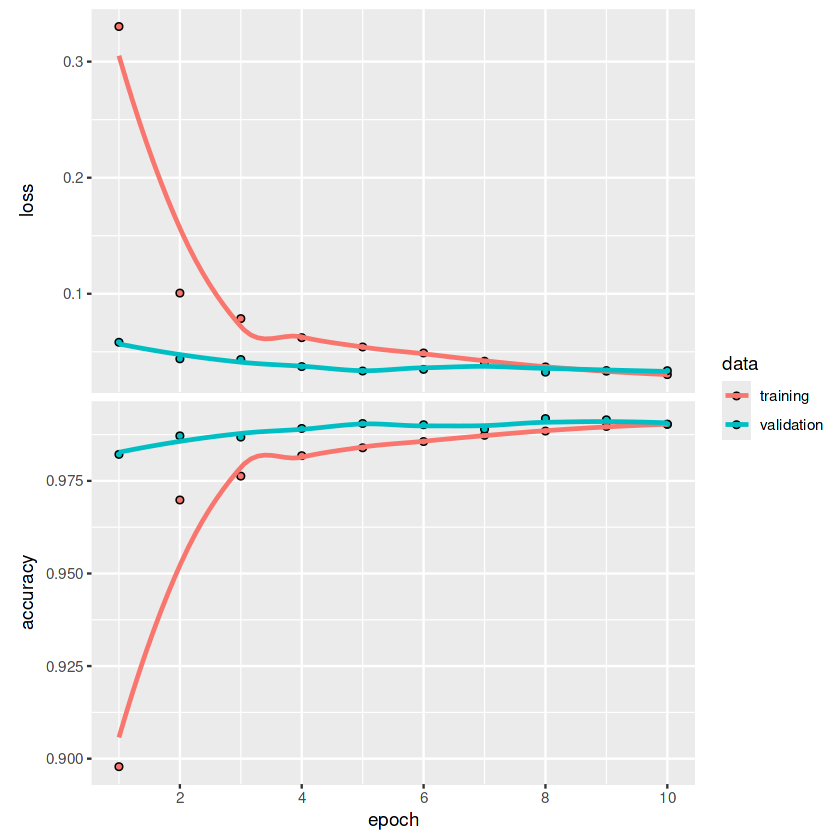

In [8]:
# Graficar el historial de entrenamiento
plot(history)

# Evaluar el modelo en el conjunto de prueba
score <- model %>% evaluate(x_test, y_test, verbose = 0)

cat('Pérdida en prueba:', score['loss'], '\n')
cat('Exactitud en prueba:', score['accuracy'], '\n')

         Actual
Predicted    0    1    2    3    4    5    6    7    8    9
        0  977    0    0    0    0    1    1    0    5    0
        1    0 1135    1    0    0    0    2    4    0    4
        2    0    0 1029    3    0    1    1    2    2    0
        3    0    0    0  999    0    4    0    0    1    0
        4    1    0    0    0  979    0    1    0    0    5
        5    0    0    0    5    0  885    1    0    1    9
        6    1    0    0    0    1    1  952    0    2    1
        7    1    0    2    2    0    0    0 1021    0    5
        8    0    0    0    1    0    0    0    1  961    3
        9    0    0    0    0    2    0    0    0    2  982


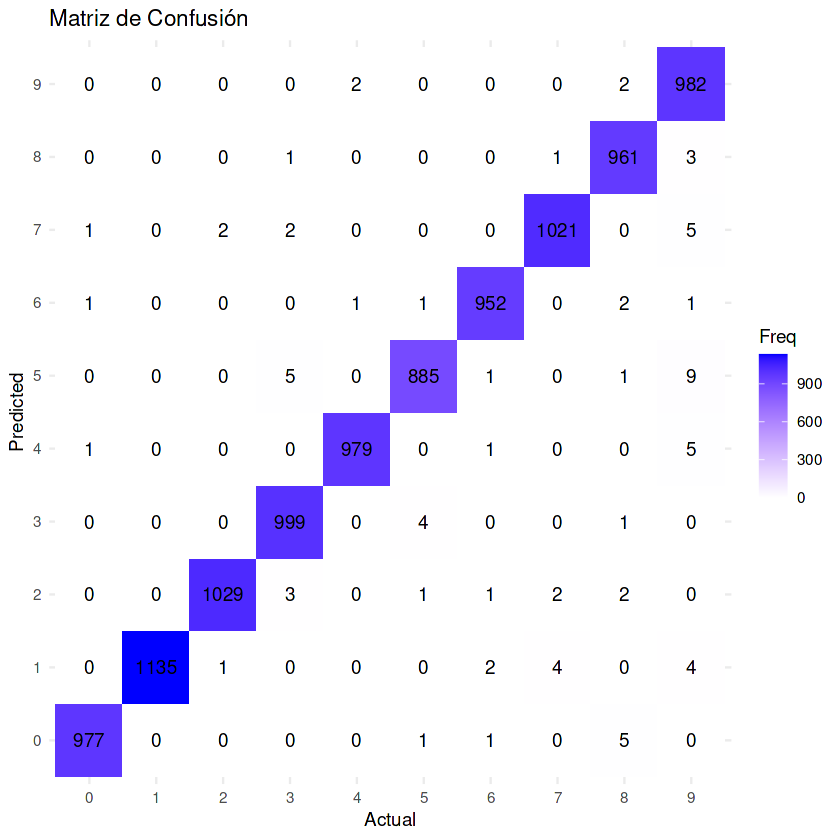

In [9]:
# Predicciones y Matriz de Confusión
predictions <- model %>% predict(x_test) %>% k_argmax()
predicted_labels <- as.integer(predictions)

true_labels <- y_test_raw

# Crear tabla de Matriz de Confusión
conf_matrix <- table(Predicted = predicted_labels, Actual = true_labels)
print(conf_matrix)

# Visualizar la Matriz de Confusión (usando ggplot)
conf_df <- as.data.frame(conf_matrix)
ggplot(conf_df, aes(x = Actual, y = Predicted, fill = Freq)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "blue") +
  geom_text(aes(label = Freq), color = "black") +
  theme_minimal() +
  labs(title = "Matriz de Confusión")

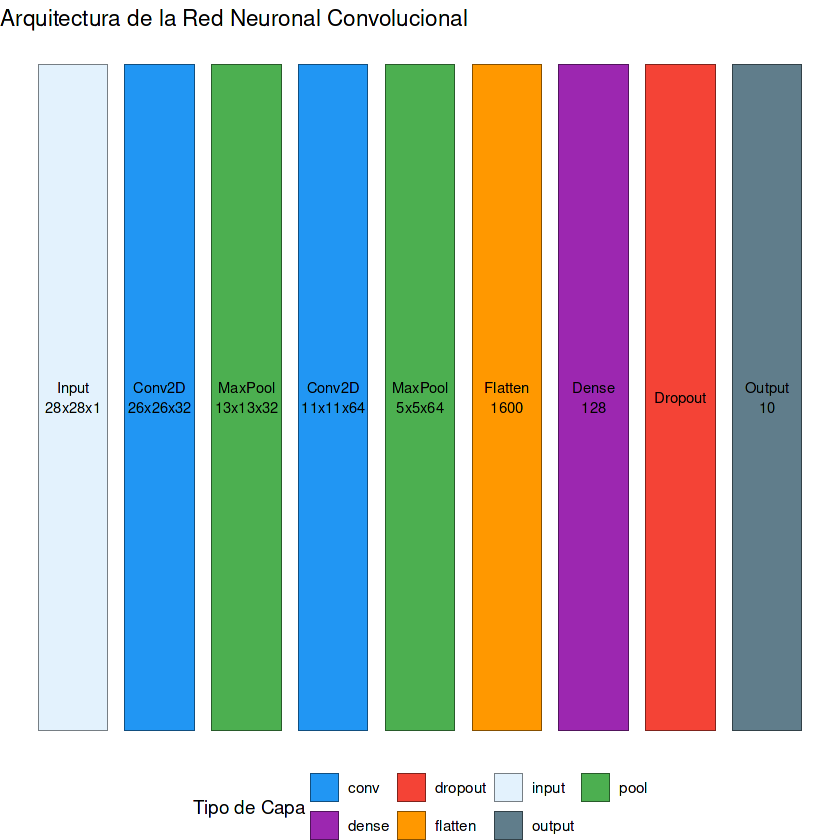

In [10]:
# Código R - Diagrama de arquitectura (requiere paquete 'DiagrammeR' o usar texto)
# Alternativa: usar plot simple

library(ggplot2)

# Crear dataframe con las capas
capas <- data.frame(
  capa = c("Input\n28x28x1", "Conv2D\n26x26x32", "MaxPool\n13x13x32", 
           "Conv2D\n11x11x64", "MaxPool\n5x5x64", "Flatten\n1600", 
           "Dense\n128", "Dropout", "Output\n10"),
  x = 1:9,
  tipo = c("input", "conv", "pool", "conv", "pool", "flatten", "dense", "dropout", "output")
)

ggplot(capas, aes(x = x, y = 1, fill = tipo)) +
  geom_tile(width = 0.8, height = 0.5, color = "black") +
  geom_text(aes(label = capa), size = 3) +
  scale_fill_manual(values = c("input" = "#E3F2FD", "conv" = "#2196F3", 
                                "pool" = "#4CAF50", "flatten" = "#FF9800",
                                "dense" = "#9C27B0", "dropout" = "#F44336", 
                                "output" = "#607D8B")) +
  theme_void() +
  theme(legend.position = "bottom") +
  labs(title = "Arquitectura de la Red Neuronal Convolucional",
       fill = "Tipo de Capa")

ggsave("img_arquitectura.png", width = 12, height = 4, dpi = 150)


Attaching package: ‘reshape2’




The following object is masked from ‘package:tidyr’:

    smiths




png 
  2

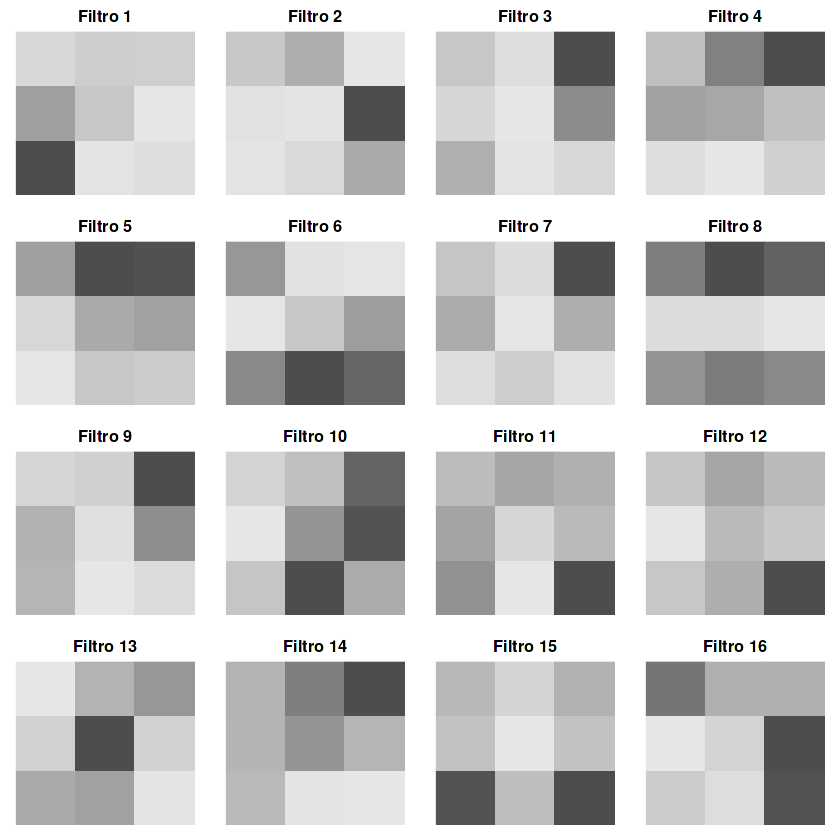

In [11]:
library(ggplot2)
library(reshape2)

# Obtener pesos de la primera capa convolucional
weights <- get_weights(model$layers[[1]])
filters <- weights[[1]]  # Shape: (3, 3, 1, 32)

# Crear visualización de los primeros 16 filtros
par(mfrow = c(4, 4), mar = c(1, 1, 2, 1))
for (i in 1:16) {
  filter_matrix <- filters[,,1,i]
  image(1:3, 1:3, t(filter_matrix[3:1,]), 
        col = gray.colors(256), axes = FALSE,
        main = paste("Filtro", i))
}

# Guardar como PNG
png("img_filtros.png", width = 800, height = 800)
par(mfrow = c(4, 4), mar = c(1, 1, 2, 1))
for (i in 1:16) {
  filter_matrix <- filters[,,1,i]
  image(1:3, 1:3, t(filter_matrix[3:1,]), 
        col = gray.colors(256), axes = FALSE,
        main = paste("Filtro", i))
}
dev.off()

In [12]:
# Crear modelo intermedio para obtener activaciones
layer_outputs <- lapply(model$layers[1:4], function(layer) layer$output)
activation_model <- keras_model(inputs = model$input, outputs = layer_outputs)

# Seleccionar una imagen de prueba
sample_img <- array_reshape(x_test[1,,,], c(1, 28, 28, 1))

# Obtener activaciones
activations <- activation_model %>% predict(sample_img)

# Visualizar activaciones de la primera capa conv (primeros 8 filtros)
png("img_activaciones.png", width = 1200, height = 400)
par(mfrow = c(2, 4), mar = c(1, 1, 2, 1))
for (i in 1:8) {
  act_map <- activations[[1]][1,,,i]
  image(1:26, 1:26, t(act_map[26:1,]), 
        col = viridis::viridis(256), axes = FALSE,
        main = paste("Activación", i))
}
dev.off()

png 
  2

In [13]:
# Código R - Visualizar errores de clasificación
library(ggplot2)

# Obtener predicciones
predictions <- model %>% predict(x_test) %>% k_argmax()
predicted_labels <- as.integer(predictions)

# Encontrar errores
errors_idx <- which(predicted_labels != y_test_raw)
cat("Total de errores:", length(errors_idx), "\n")

# Visualizar primeros 12 errores
png("img_errores.png", width = 1000, height = 800)
par(mfrow = c(3, 4), mar = c(1, 1, 3, 1))
for (i in 1:min(12, length(errors_idx))) {
  idx <- errors_idx[i]
  img_mat <- x_test[idx,,,1]
  img_mat <- t(apply(img_mat, 2, rev))
  
  image(1:28, 1:28, img_mat, col = gray((0:255)/255), axes = FALSE,
        main = paste("Real:", y_test_raw[idx], "| Pred:", predicted_labels[idx]))
}
dev.off()

Total de errores: 80 


png 
  2

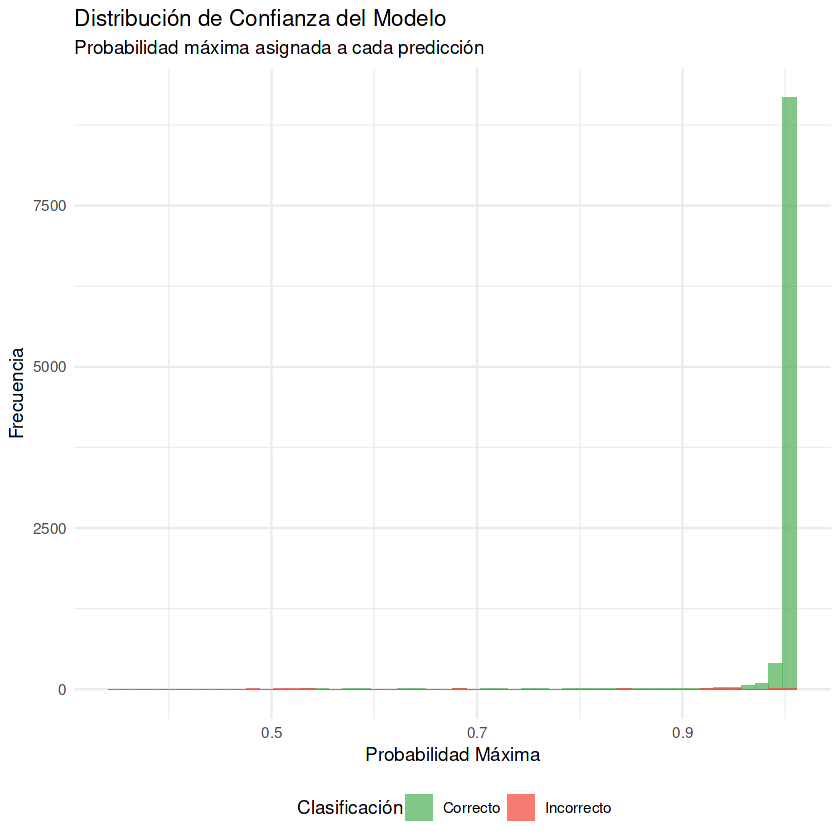

In [14]:
# Código R - Distribución de probabilidades máximas
library(ggplot2)

# Obtener probabilidades
probs <- model %>% predict(x_test)
max_probs <- apply(probs, 1, max)

# Crear dataframe
prob_df <- data.frame(
  probabilidad = max_probs,
  correcto = ifelse(predicted_labels == y_test_raw, "Correcto", "Incorrecto")
)

# Histograma
ggplot(prob_df, aes(x = probabilidad, fill = correcto)) +
  geom_histogram(bins = 50, alpha = 0.7, position = "identity") +
  scale_fill_manual(values = c("Correcto" = "#4CAF50", "Incorrecto" = "#F44336")) +
  theme_minimal() +
  labs(title = "Distribución de Confianza del Modelo",
       subtitle = "Probabilidad máxima asignada a cada predicción",
       x = "Probabilidad Máxima",
       y = "Frecuencia",
       fill = "Clasificación") +
  theme(legend.position = "bottom")

ggsave("img_confianza.png", width = 10, height = 6, dpi = 150)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


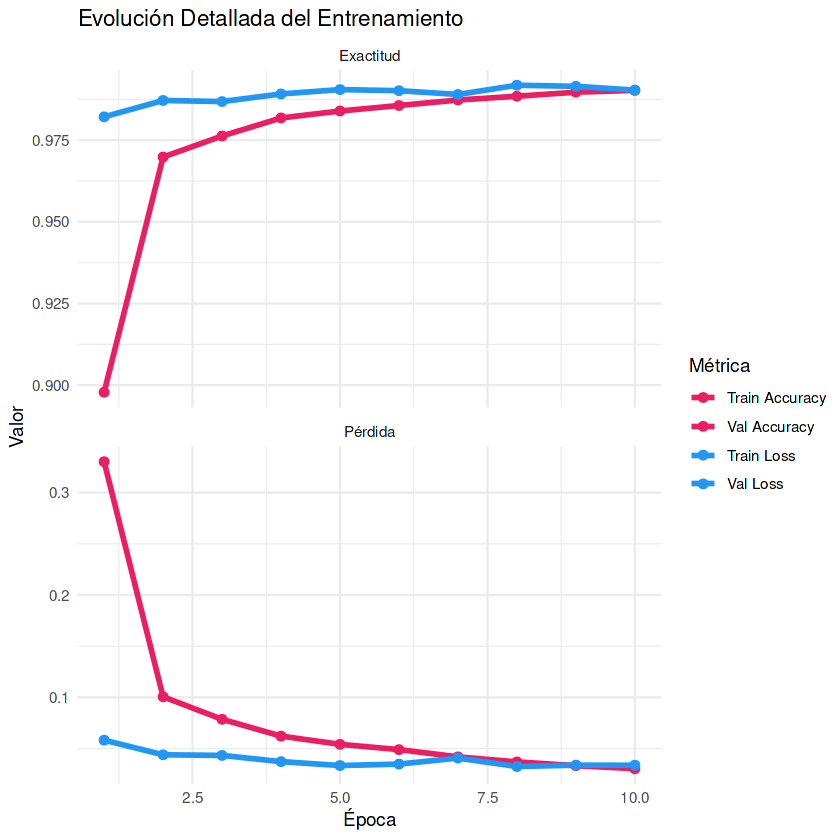

In [15]:
# Código R - Tabla de métricas por época
library(ggplot2)
library(tidyr)

# Crear dataframe del historial
hist_df <- data.frame(
  epoca = 1:length(history$metrics$accuracy),
  train_acc = history$metrics$accuracy,
  val_acc = history$metrics$val_accuracy,
  train_loss = history$metrics$loss,
  val_loss = history$metrics$val_loss
)

# Transformar a formato largo
hist_long <- pivot_longer(hist_df, cols = -epoca, names_to = "metrica", values_to = "valor")

# Gráfico facetado
ggplot(hist_long, aes(x = epoca, y = valor, color = metrica)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  facet_wrap(~ifelse(grepl("acc", metrica), "Exactitud", "Pérdida"), 
             scales = "free_y", ncol = 1) +
  scale_color_manual(values = c("train_acc" = "#E91E63", "val_acc" = "#2196F3",
                                 "train_loss" = "#E91E63", "val_loss" = "#2196F3"),
                     labels = c("Train Accuracy", "Val Accuracy", 
                               "Train Loss", "Val Loss")) +
  theme_minimal() +
  labs(title = "Evolución Detallada del Entrenamiento",
       x = "Época", y = "Valor", color = "Métrica")

ggsave("img_evolucion.png", width = 10, height = 8, dpi = 150)

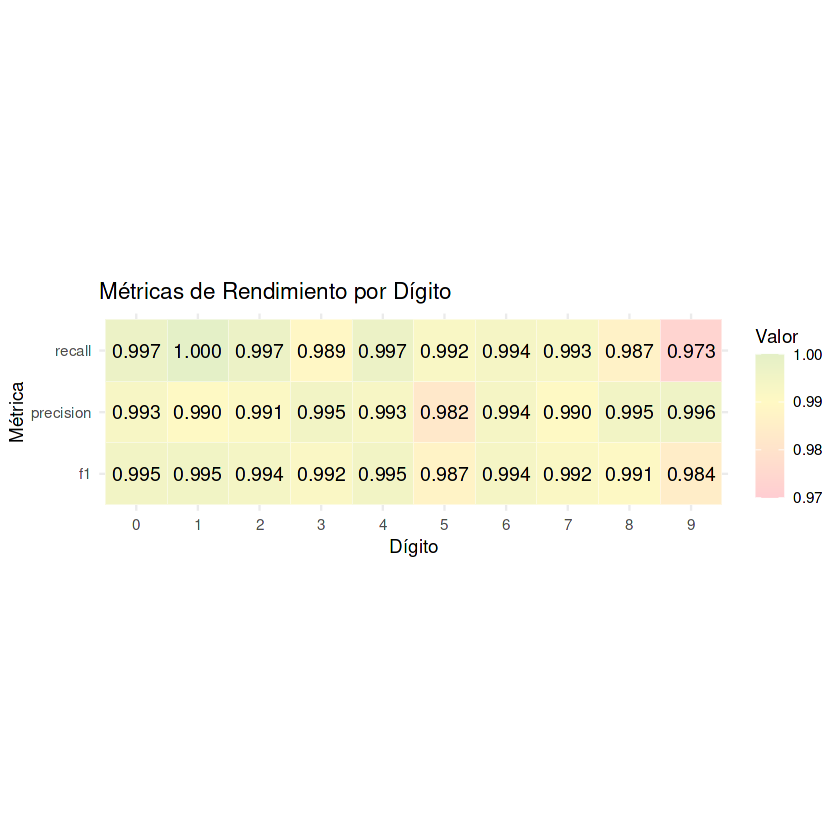

In [16]:
# Código R - Heatmap de métricas por clase
library(ggplot2)

# Calcular métricas por clase
metricas_clase <- data.frame(
  digito = 0:9,
  precision = sapply(0:9, function(d) {
    pred_d <- predicted_labels == d
    real_d <- y_test_raw == d
    sum(pred_d & real_d) / sum(pred_d)
  }),
  recall = sapply(0:9, function(d) {
    pred_d <- predicted_labels == d
    real_d <- y_test_raw == d
    sum(pred_d & real_d) / sum(real_d)
  })
)
metricas_clase$f1 <- 2 * (metricas_clase$precision * metricas_clase$recall) / 
                      (metricas_clase$precision + metricas_clase$recall)

# Transformar a formato largo
metricas_long <- pivot_longer(metricas_clase, cols = -digito, 
                               names_to = "metrica", values_to = "valor")

# Heatmap
ggplot(metricas_long, aes(x = as.factor(digito), y = metrica, fill = valor)) +
  geom_tile(color = "white") +
  geom_text(aes(label = sprintf("%.3f", valor)), color = "black", size = 4) +
  scale_fill_gradient2(low = "#FFCDD2", mid = "#FFF9C4", high = "#C8E6C9", 
                       midpoint = 0.99, limits = c(0.97, 1)) +
  theme_minimal() +
  labs(title = "Métricas de Rendimiento por Dígito",
       x = "Dígito", y = "Métrica", fill = "Valor") +
  coord_fixed()

ggsave("img_metricas_clase.png", width = 10, height = 4, dpi = 150)

# Fase 8: Conclusión

## Conclusión del Proyecto

En el presente estudio se desarrolló y entrenó una Red Neuronal Convolucional (CNN) para la clasificación de dígitos manuscritos utilizando el conjunto de datos MNIST. Los resultados obtenidos demuestran la eficacia del modelo y permiten extraer las siguientes conclusiones:

1. **Exploración y Comprensión de Datos**  
   El análisis inicial de los datos evidenció que el conjunto de imágenes está balanceado, compuesto por imágenes en escala de grises de 28×28 píxeles correspondientes a los dígitos del 0 al 9. Esta verificación aseguró la calidad y consistencia de los datos para el posterior entrenamiento de la red neuronal.

2. **Preprocesamiento de Datos**  
   Se aplicaron pasos fundamentales de preprocesamiento: reestructuración de las matrices de píxeles al formato requerido por Keras, normalización de los valores de píxeles al rango [0, 1] y codificación one-hot de las etiquetas. Estas transformaciones fueron esenciales para garantizar que los datos fueran compatibles con la arquitectura de la CNN y facilitaran un entrenamiento eficiente.

3. **Arquitectura del Modelo**  
   La CNN diseñada incluyó bloques convolucionales y de pooling para la extracción automática de características, seguidos de capas Flatten y Dense para la interpretación de dichas características y la clasificación final. La incorporación de capas de Dropout permitió reducir el riesgo de sobreajuste, asegurando un modelo más robusto.

4. **Resultados del Entrenamiento**  
   El modelo alcanzó aproximadamente un 99% de exactitud en los conjuntos de entrenamiento, validación y prueba. Las curvas de pérdida y precisión mostraron un aprendizaje estable, sin indicios de sobreajuste, lo que confirma la efectividad de la estrategia de entrenamiento y del preprocesamiento aplicado.

5. **Evaluación del Modelo**  
   La matriz de confusión evidenció un número muy reducido de errores de clasificación, principalmente entre dígitos con formas similares. El reporte de clasificación indicó métricas de precisión, recall y F1-score cercanas a 0.99 para todas las clases, lo que respalda la capacidad predictiva del modelo.

6. **Implementación y Uso Futuro**  
   El modelo entrenado se guardó en formato `.h5`, lo que permite su reutilización en futuras aplicaciones sin necesidad de reentrenamiento, facilitando su implementación en entornos de producción.

### Conclusiones Generales

El estudio demuestra que las CNN son capaces de aprender patrones complejos a partir de imágenes, desde bordes hasta formas completas de dígitos, de manera automática. Además, resalta la importancia del preprocesamiento adecuado y del diseño de la arquitectura para alcanzar un alto desempeño. La monitorización de métricas durante el entrenamiento y la validación resulta fundamental para prevenir sobreajuste o subajuste. Finalmente, se evidenció que incluso una CNN de arquitectura relativamente simple puede lograr resultados de precisión comparables al estado del arte en el conjunto de datos MNIST.


In [17]:
save_model_hdf5(model, "mnist_cnn_model.h5")
cat("MODELO GUARDADO")

MODELO GUARDADO